In [1]:
# Basic libraries
import torch
import torch.nn as n
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List, Tuple, Optional
import torch.optim as optim
from tqdm import tqdm
from omegaconf import OmegaConf
from matplotlib.patches import Rectangle

In [2]:
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder, VanillaDecoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *
from osgen.loss import *
from osgen.pipeline import *

In [3]:

# Load config
cfg = OmegaConf.load("/root/BiOSGen/configs/train_config.yml")
print(cfg.verbose)

True


In [4]:
# Directory where your tumor PNGs are stored
directory = '/root/BiOSGen/data/NKX3'

for filename in os.listdir(directory):
    if filename.endswith('.png') and 'NKX3' not in filename and 'NKX' in filename:
        new_filename = filename.replace('NKX', 'NKX3')
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)
        os.rename(old_path, new_path)
        print(f'Renamed: {filename} -> {new_filename}')

In [5]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


In [6]:
def extract_bboxes_for_patch(bbox_info, patch_coords, patch_size):
    """
    Extracts bounding boxes within a patch from the full-image bbox_info.

    Args:
        bbox_info: np.ndarray of shape (N, 5) — [y0, x0, y1, x1, label]
        patch_coords: tuple — (y_start, x_start)
        patch_size: tuple — (patch_height, patch_width)

    Returns:
        patch_bboxes: np.ndarray of filtered & shifted bounding boxes
                      relative to the patch
    """
    y_start, x_start = patch_coords
    patch_h, patch_w = patch_size
    y_end = y_start + patch_h
    x_end = x_start + patch_w

    patch_bboxes = []

    for bbox in bbox_info:
        y0, x0, y1, x1, label = bbox

        # Check if bbox intersects the patch
        if y1 <= y_start or y0 >= y_end or x1 <= x_start or x0 >= x_end:
            continue  # Outside

        # Clip bbox to patch
        clipped_y0 = np.clip(y0 - y_start, 0, patch_h)
        clipped_x0 = np.clip(x0 - x_start, 0, patch_w)
        clipped_y1 = np.clip(y1 - y_start, 0, patch_h)
        clipped_x1 = np.clip(x1 - x_start, 0, patch_w)

        patch_bboxes.append([clipped_y0, clipped_x0, clipped_y1, clipped_x1, label])

    return np.array(patch_bboxes)


In [7]:
@staticmethod
def get_image_patches_with_bboxes(
    image: np.ndarray,
    bbox_info: np.ndarray,
    patch_size: int = 512,
    is_visualize: bool = False
) -> List[Tuple[np.ndarray, np.ndarray]]:
    """
    Returns:
        List of tuples: (patch image, corresponding bbox_info in patch)
    """
    h, w, _ = image.shape

    # Padding
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size
    image_padded = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant', constant_values=255)

    if is_visualize:
        fig, ax = plt.subplots()
        ax.imshow(Image.fromarray(image_padded))

    patches_with_bboxes = []
    for y in range(0, image_padded.shape[0], patch_size):
        for x in range(0, image_padded.shape[1], patch_size):
            patch = image_padded[y:y + patch_size, x:x + patch_size]

            # Filter and adjust bboxes for this patch
            patch_bboxes = []
            for bbox in bbox_info:
                y0, x0, y1, x1, label = bbox

                # Check if box intersects with current patch
                if y1 <= y or y0 >= y + patch_size or x1 <= x or x0 >= x + patch_size:
                    continue

                # Clip and translate bbox to patch-relative coords
                new_y0 = np.clip(y0 - y, 0, patch_size)
                new_x0 = np.clip(x0 - x, 0, patch_size)
                new_y1 = np.clip(y1 - y, 0, patch_size)
                new_x1 = np.clip(x1 - x, 0, patch_size)
                patch_bboxes.append([new_y0, new_x0, new_y1, new_x1, label])

            patches_with_bboxes.append((patch, np.array(patch_bboxes)))

            if is_visualize:
                rect = Rectangle((x, y), patch_size, patch_size, linewidth=1, edgecolor='green', facecolor='none')
                ax.add_patch(rect)

    if is_visualize:
        plt.title(f"Total patches: {len(patches_with_bboxes)}")
        plt.show()

    return patches_with_bboxes


/tmp/ipykernel_15248/3337813458.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bbox_info=np.load(tree_src.npz[0])['bbox'],


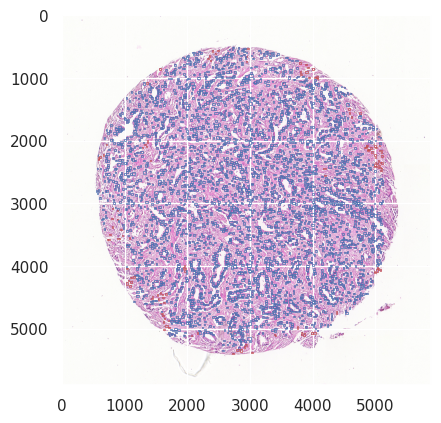

In [8]:
PatchesUtilities.plot_nuclei_labels(
    image=np.array(Image.open(tree_src.antibodies[0])),
    bbox_info=np.load(tree_src.npz[0])['bbox'],
)

In [9]:
np.load(tree_src.npz[0])['bbox'].shape

/tmp/ipykernel_15248/2050601566.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.load(tree_src.npz[0])['bbox'].shape


(3903, 5)

In [10]:
import numpy as np

# Your bbox array
bbox_info = np.load(tree_src.npz[0])['bbox']

# Sort by x0 (col 1), then x1 (col 2)
sorted_bbox = bbox_info[np.lexsort((bbox_info[:, 2], bbox_info[:, 1]))]

print(sorted_bbox)


[[2795  552 2821  567    1]
 [2433  561 2460  580    1]
 [2834  568 2858  584    1]
 ...
 [2624 5100 2641 5119    1]
 [2952 5100 2975 5120    1]
 [3616 5112 3642 5120    1]]


/tmp/ipykernel_15248/3756708387.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bbox_info = np.load(tree_src.npz[0])['bbox']


In [11]:
p, b = PatchesUtilities.get_full_info(
    image = np.array(Image.open(tree_dst.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[0]))),
    is_visualize = True,
    bbox_info = np.load(tree_dst.npz[0])['bbox']
)

/tmp/ipykernel_15248/3662358035.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bbox_info = np.load(tree_dst.npz[0])['bbox']


In [12]:
len(b[10])

31

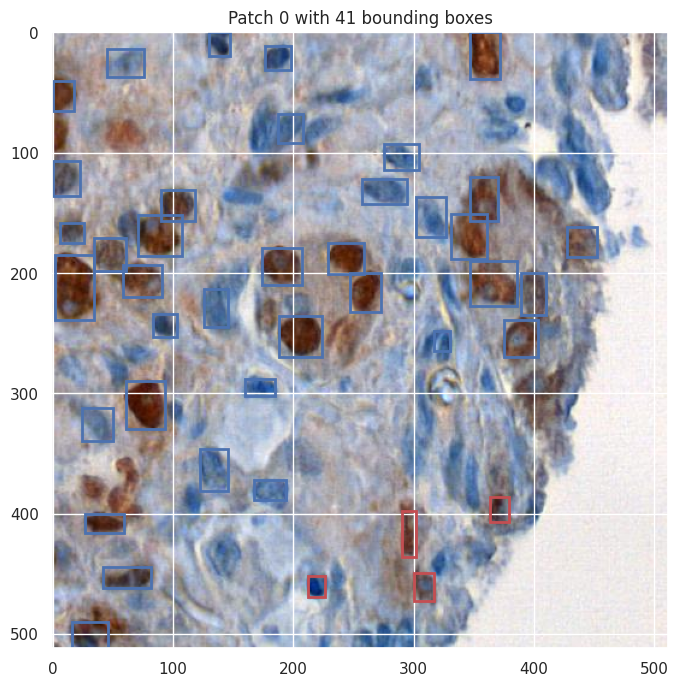

In [13]:
PatchesUtilities.visualize_patch_with_bboxes(
    patch = p[50],
    bboxes = b[50],
)

In [ ]:
import torch
import torch.nn.functional as F

def compute_roi_style_loss(x_gen: torch.Tensor, 
                           x_orig: torch.Tensor, 
                           bbox_info: torch.Tensor, 
                           patch_size: int = 512,
                           class_weights: dict = None) -> torch.Tensor:
    """
    Compute an ROI-aware style loss between generated and original patches.

    Args:
        x_gen (Tensor): Generated image patch. Shape: [1, C, H, W]
        x_orig (Tensor): Original image patch. Shape: [1, C, H, W]
        bbox_info (Tensor): Bounding box info (tensor of [y0, x0, y1, x1, label])
        patch_size (int): Size of the patch. Default: 512
        class_weights (dict): Optional class weighting. Example: {0: 1.0, 1: 2.0}

    Returns:
        Tensor: Scalar loss value (style-aware L1 loss in tumor ROI)
    """

    # Ensure input shape
    assert x_gen.shape == x_orig.shape, "Generated and original images must be same shape"
    assert x_gen.shape[2] == patch_size and x_gen.shape[3] == patch_size, "Patch size mismatch"

    device = x_gen.device
    mask = torch.zeros(1, 1, patch_size, patch_size, device=device)

    # Generate ROI mask
    for box in bbox_info:
        y0, x0, y1, x1, label = map(int, box.tolist())

        weight = 1.0
        if class_weights is not None:
            weight = class_weights.get(label, 1.0)
        
        mask[:, :, y0:y1, x0:x1] = weight

    # Compute masked L1 loss
    l1 = torch.abs(x_gen - x_orig)
    masked_l1 = l1 * mask  # Focus only inside ROI
    loss = masked_l1.sum() / mask.sum().clamp(min=1.0)  # Normalize by area

    return loss


In [15]:
device = 'cuda'
x_gen = torch.randn(1, 3, 512, 512).to(device)       # generated patch
x_orig = torch.randn(1, 3, 512, 512).to(device)      # original patch
bbox_info = torch.tensor([[50, 60, 100, 110, 1],
                          [200, 220, 250, 260, 0]]).to(device)  # [y0, x0, y1, x1, label]

loss = compute_roi_style_loss(
    x_gen, x_orig, bbox_info, 
    patch_size=512, 
    class_weights={0: 1.0, 1: 2.0}  # optional class importance
)


In [16]:
loss

tensor(3.3645, device='cuda:0')

In [39]:
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()

patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[idx_dst]))),
)
p, b = PatchesUtilities.get_full_info(
    image = np.array(Image.open(tree_src.antibodies[idx_dst])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_dst]))),
    is_visualize = True,
    bbox_info = np.load(tree_src.npz[idx_dst])['bbox']
)

print("Number of bbox in source antibody: ", len(b))
print("Number of patches in source antibody: ", len(patches_src))
print("Number of patches in destination antibody: ", len(patches_dst))
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

Number of bbox in source antibody:  83
Number of patches in source antibody:  95
Number of patches in destination antibody:  94
idx_src:  20
idx_dst:  60


/tmp/ipykernel_15248/3884398441.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bbox_info = np.load(tree_src.npz[idx_dst])['bbox']


In [44]:
# Initialize your pipeline
pipeline = OSGenPipeline()

In [46]:
# Hyperparameters
verbose = cfg.verbose
num_epochs = 10
batch_size = cfg.batch_size
lr = cfg.lr
optimizer = optim.AdamW([p for p in pipeline.parameters() if p.requires_grad], 
                        lr=cfg.optimizer.params.lr, weight_decay=cfg.optimizer.params.weight_decay, eps=cfg.optimizer.params.eps)

channels = cfg.channels
height = cfg.height
width = cfg.width
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lambda_content = cfg.lambda_content
lambda_style = cfg.lambda_style

# Training loop
# Put on training mode
pipeline.train()
requires_grad = True

# Early stopping parameters
early_stopping_patience = cfg.early_stopping_patience
epochs_without_improvement = 0
best_loss = float("inf")

# Convergence check parameters
convergence_patience = 5  # Number of epochs to check for convergence
convergence_threshold = 0.001  # Minimum relative change in loss to continue training
loss_history = []  # Keep track of recent losses

# Save losses
losses = []
content_losses = []
style_losses = []

# Switch to main training with bfloat16
for epoch in tqdm(range(num_epochs)):
    # print(f"Epoch {epoch+1}/{num_epochs}")
    avg_loss = []
    content_loss = []
    style_loss = []

    for i, (src, dst) in enumerate(zip(patches_src, patches_dst)):
        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        bbox_info = b[i]

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        decoded = pipeline(src_tensor, dst_tensor, timesteps)

        # Handle gradients issues
        requires_grad = decoded.requires_grad
        # print(requires_grad)
        if not requires_grad:
            break

        # Compute loss
        content_l, style_l, total_loss = pipeline.compute_loss(src_tensor, dst_tensor, decoded, lambda_content, lambda_style)

        loss = compute_roi_style_loss(
            decoded, dst_tensor, bbox_info, 
            patch_size=512, 
            class_weights={0: 1.0, 1: 2.0}  # optional class importance
        )
        total_loss += 0.1 + loss  # Add the ROI-aware style loss

        # Break if total_loss is NaN
        if torch.isnan(total_loss):
            print(f"NaN loss at epoch {epoch+1}, batch {i+1}")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
                f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
                f"Loss for patch {i+1}: {loss.item():.4f}, "
                f"Total Loss: {total_loss.item():.4f}")

        avg_loss.append(total_loss.item())
        content_loss.append(content_l.item())
        style_loss.append(style_l.item())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
    current_loss = np.mean(avg_loss)
    losses.append(current_loss)
    content_losses.append(np.mean(content_loss))
    style_losses.append(np.mean(style_loss))

    # Early stopping (original implementation)
    if current_loss < best_loss:
        best_loss = current_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if verbose: 
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
                f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
                f"Total Loss: {total_loss.item():.4f}")
            
            # Save the checkpoints
            torch.save(pipeline.state_dict(), f"/root/BiOSGen/checkpoints/pipeline_epoch_{epoch+1}.pth")
            print(f"Model saved at /root/BiOSGen/checkpoints/pipeline_epoch_{epoch+1}.pth")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Batch 1/95, Content Loss: 26.0888, Style Loss: 9.5257, Loss for patch 1: 0.0000, Total Loss: 35.7146
Epoch 1/10, Batch 2/95, Content Loss: 75.0013, Style Loss: 37.1937, Loss for patch 2: 229.5388, Total Loss: 341.8339
Epoch 1/10, Batch 3/95, Content Loss: 65.2483, Style Loss: 40.0416, Loss for patch 3: 271.1008, Total Loss: 376.4907
Epoch 1/10, Batch 4/95, Content Loss: 43.3704, Style Loss: 26.0372, Loss for patch 4: 215.4397, Total Loss: 284.9472
Epoch 1/10, Batch 5/95, Content Loss: 43.0157, Style Loss: 9.5338, Loss for patch 5: 87.2962, Total Loss: 139.9457
Epoch 1/10, Batch 6/95, Content Loss: 90.1597, Style Loss: 13.6392, Loss for patch 6: 0.0000, Total Loss: 103.8989
Epoch 1/10, Batch 7/95, Content Loss: 86.8568, Style Loss: 6.6968, Loss for patch 7: 0.0000, Total Loss: 93.6537
Epoch 1/10, Batch 8/95, Content Loss: 68.6219, Style Loss: 13.8344, Loss for patch 8: 164.1024, Total Loss: 246.6587
Epoch 1/10, Batch 9/95, Content Loss: 71.7132, Style Loss: 5.6821, Loss for 

  0%|          | 0/10 [00:04<?, ?it/s]

Epoch 1/10, Batch 29/95, Content Loss: 66.5713, Style Loss: 14.3978, Loss for patch 29: 215.7433, Total Loss: 296.8125


KeyboardInterrupt: 

Text(0.5, 1.0, 'Generated Image')

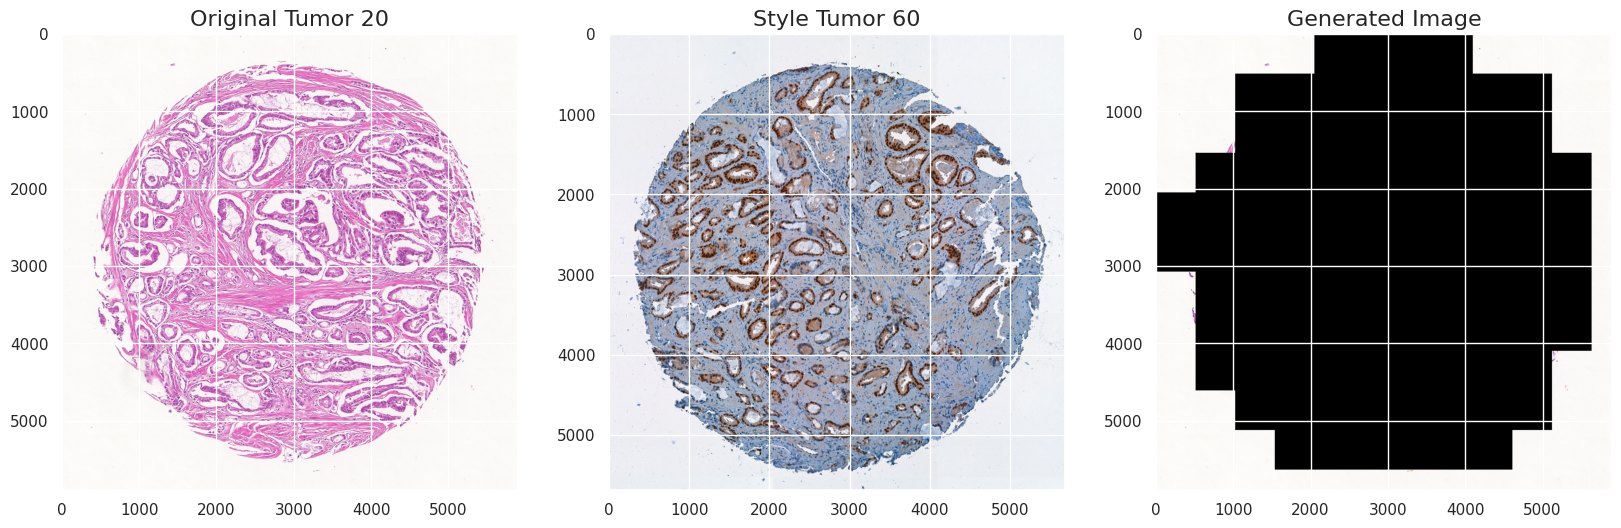

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[torch.randint(0, len(patches_dst), (1,)).item()]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = PatchesUtilities.replace_patches_in_image(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask=PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)

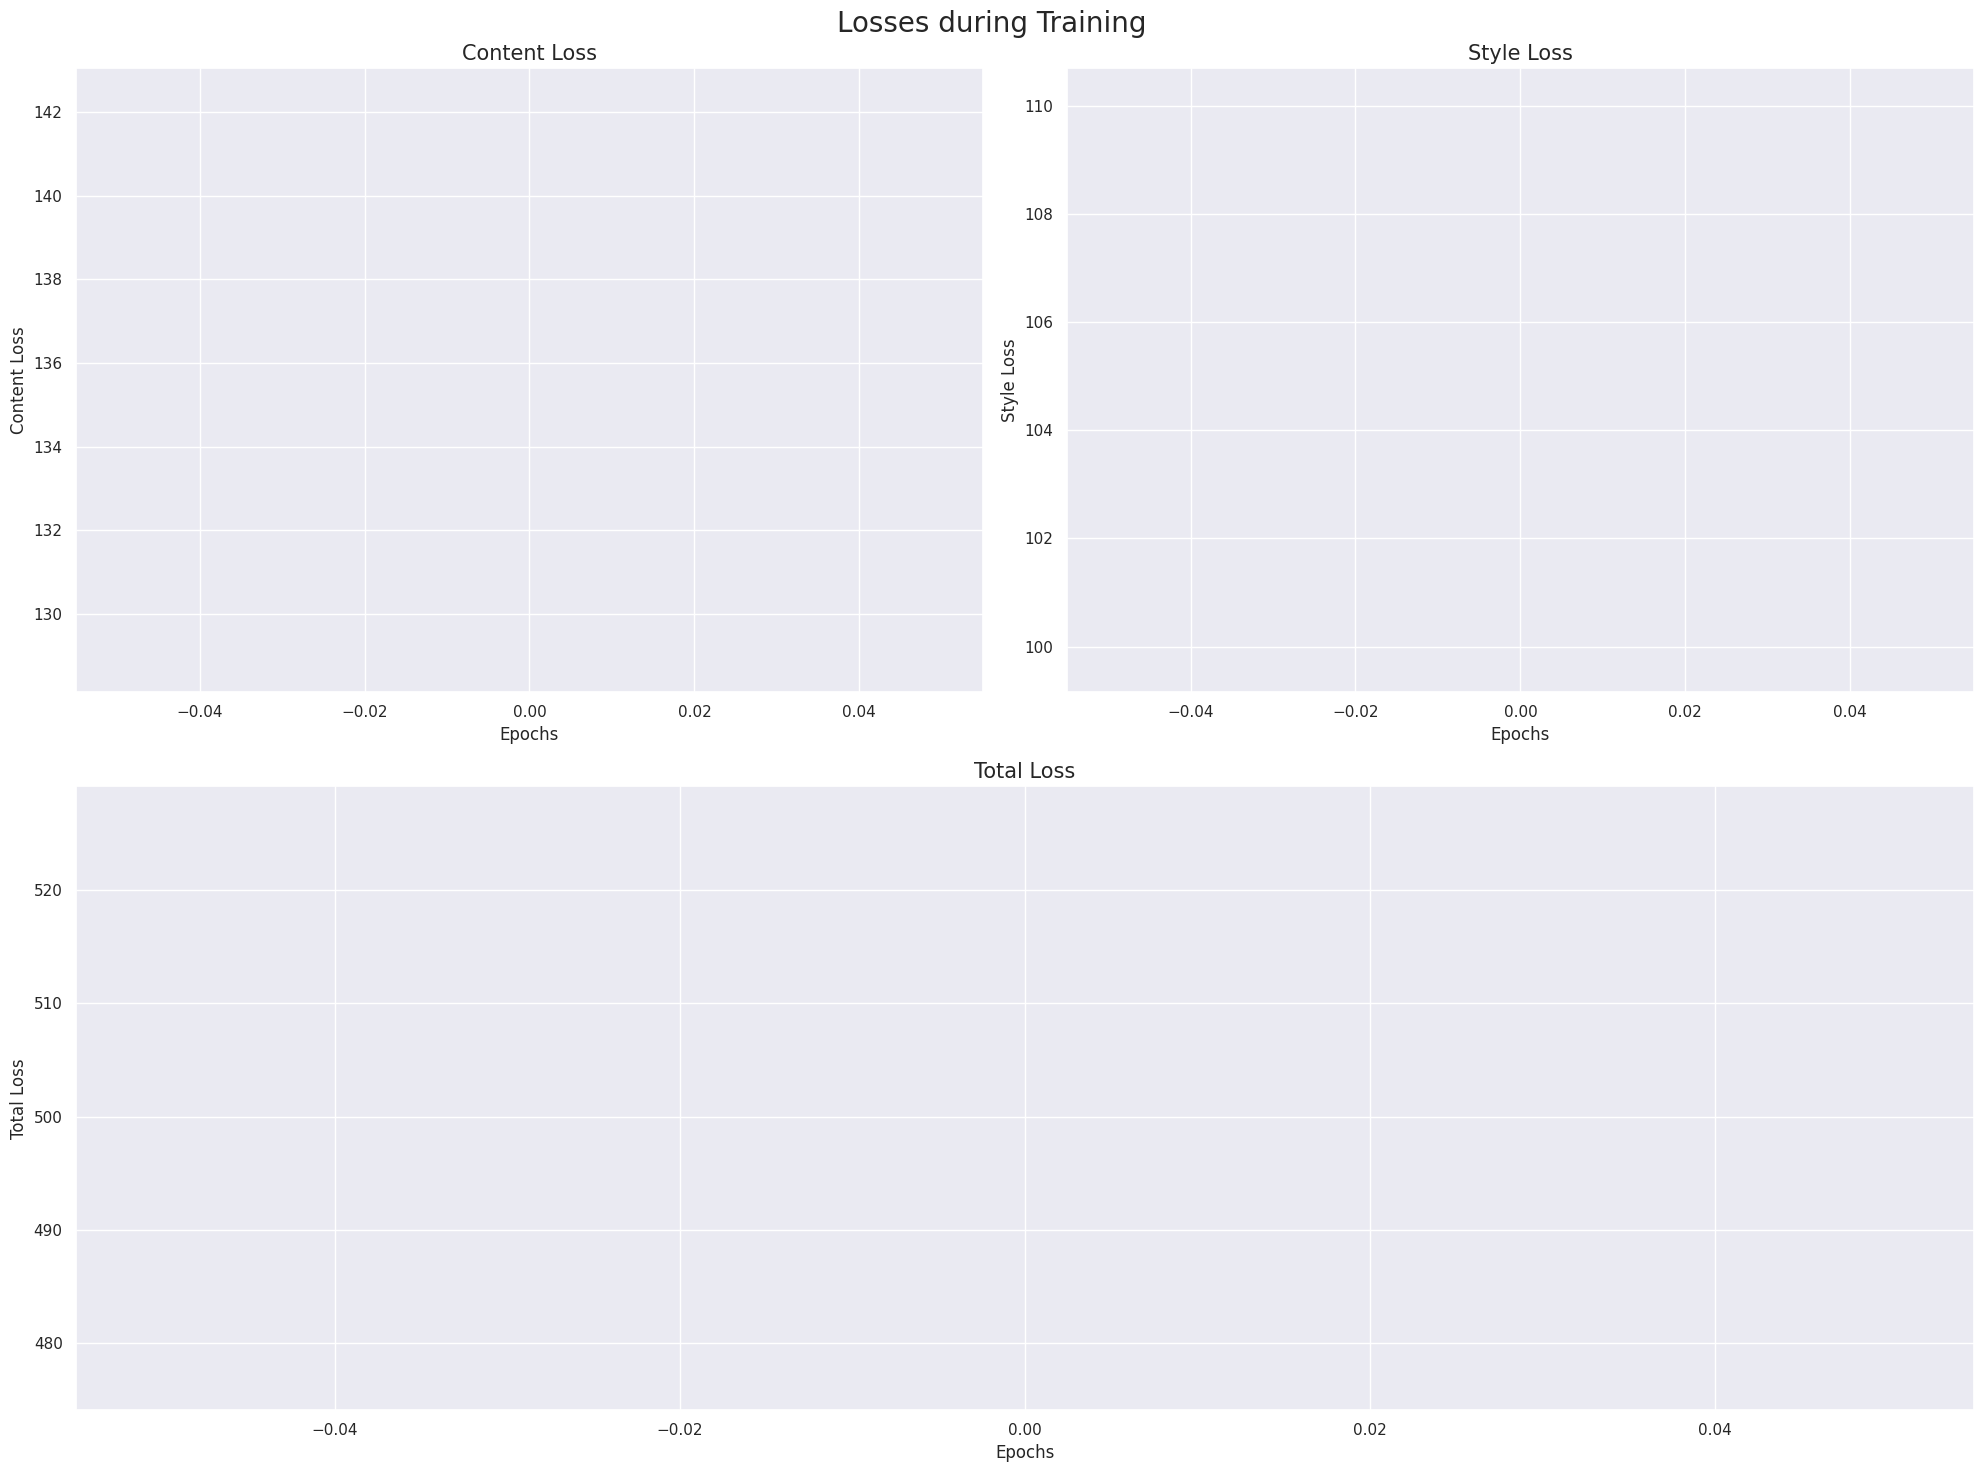

In [43]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Upper left: Content Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(content_losses, label='Content Loss')
ax1.set_title('Content Loss', fontsize=15)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Content Loss')

# Upper right: Style Loss
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(style_losses, label='Style Loss')
ax2.set_title('Style Loss', fontsize=15)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Style Loss')

# Bottom (spans both columns): Total Loss
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(losses, label='Total Loss', color='red')
ax3.set_title('Total Loss', fontsize=15)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Total Loss')

# Add title to fig
fig.suptitle('Losses during Training', fontsize=20)
plt.tight_layout()
plt.show()